In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the data from 538 and weltfussball.de:
spi = pd.read_csv('spi_plus.csv')

In [3]:
# Selecting only the matches for which data from weltfussball.de could have been added:
spi = spi[spi.season.notnull()].reset_index(drop=True)

# Selecting only relevant columns:
spi = spi[['date', 'league_id', 'league', 'team1', 'team2', 'spi1', 'spi2',
       'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2',
       'importance1', 'importance2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1',
       'nsxg2', 'adj_score1', 'adj_score2', 'season',
       'Spieltag', 'draw_time', 'home_lead', 'away_lead']]

In [4]:
spi.rename(columns={'Spieltag': 'matchday'}, inplace=True) # just replacing the German word by its English equivalent

In [5]:
spi.drop([90], inplace=True) # The game Sassuolo - Calcio on 08/28, 2016 has been declared invalid.

In [6]:
# Calculating the match length, as per the data:
(spi.draw_time + spi.home_lead + spi.away_lead).value_counts()

# Most matches have match length of 93 minutes, but some have 92 minutes because no extra minute in the 1st half had been added.

93.0    9371
92.0    1506
dtype: int64

In [7]:
spi.league.unique() # these are the leagues

array(['French Ligue 1', 'Barclays Premier League', 'Italy Serie A',
       'German Bundesliga', 'Spanish Primera Division',
       'Mexican Primera Division Torneo Clausura', 'Brasileiro Série A',
       'German 2. Bundesliga', 'English League Championship',
       'Portuguese Liga', 'Chinese Super League', 'Italy Serie B',
       'Australian A-League'], dtype=object)

In [8]:
spi.season.unique() # some seaons' names are wrong, but that doesn't matter

array(['2016/2017', ' Clausura', 'ie A 2017', '2017/2018', 'ie A 2018',
       'ague 2018', '2018/2019', 'ague 2019', 'ie A 2019', '2019/2020'],
      dtype=object)

In [9]:
# For convenience, this changes the goal columns from floats into integers:
spi['score1'] = [int(n) for n in spi.score1]
spi['score2'] = [int(n) for n in spi.score2]

# In the following, many columns are created. Some of them are only for experimental purposes.

In [10]:
# Calculates the mean score, as 538 does, of adjusted goals, xG, and non-shot:
spi['ms1'] = (spi.adj_score1 + spi.xg1 + spi.nsxg1) / 3
spi['ms2'] = (spi.adj_score2 + spi.xg2 + spi.nsxg2) / 3

In [11]:
# Calculates the performance of a team with respect to xg, nsxg, and ms.
# If the value is positive, the team has overperformed:
spi['xg_perf1'] = spi.score1 - spi.xg1
spi['xg_perf2'] = spi.score2 - spi.xg2
spi['nsxg_perf1'] = spi.score1 - spi.nsxg1
spi['nsxg_perf2'] = spi.score2 - spi.nsxg2
spi['ms_perf1'] = spi.score1 - spi.ms1
spi['ms_perf2'] = spi.score2 - spi.ms2

In [12]:
# Determines winner, loser, main leader, and who is not the main leader.
# The main leader is the team who is leading more than the opponent.
# The duration during which the winner or main leader are behind are subtracted from the time they are leading.
spi['win'] = spi.apply(lambda x: x.team1 if x.score1 > x.score2 else (x.team2 if x.score1 < x.score2 else 'draw'), axis=1)
spi['ml'] = spi.apply(lambda x: x.team1 if x.home_lead > x.away_lead else (x.team2 if x.home_lead < x.away_lead else 'no main leader'), axis=1)
spi['win_time'] = spi.apply(lambda x: x.home_lead - x.away_lead if x.win == x.team1 else (x.away_lead - x.home_lead if x.win == x.team2 else None), axis=1)
spi['ml_time'] = spi.apply(lambda x: x.home_lead - x.away_lead if x.ml == x.team1 else (x.away_lead - x.home_lead if x.ml == x.team2 else None), axis=1)
spi['loser'] = spi.apply(lambda x: x.team1 if x.win == x.team2 else (x.team2 if x.win == x.team1 else 'draw'), axis=1)
spi['ml_behind'] = spi.apply(lambda x: x.team1 if x.ml == x.team2 else (x.team2 if x.ml == x.team1 else 'draw'), axis=1)

In [13]:
# Sums totals of goals, xg, and nsxg, determines number of goals of the winner:
spi['goals_total'] = spi.score1 + spi.score2
spi['xg_total'] = spi.xg1 + spi.xg2
spi['nsxg_total'] = spi.nsxg1 + spi.nsxg2
spi['win_goals'] = spi.apply(lambda x: x.score1 if x.win == x.team1 else (x.score2 if x.win == x.team2 else None), axis=1)

In [14]:
# Determines the difference of goals, xg, nsxg, and ms with respect to winner and main leader:
spi['goal_diff_win'] = spi.apply(lambda x: x.score1 - x.score2 if x.win == x.team1 else (x.score2 - x.score1 if x.win == x.team2 else None), axis=1)
spi['goal_diff_ml'] = spi.apply(lambda x: x.score1 - x.score2 if x.ml == x.team1 else (x.score2 - x.score1 if x.ml == x.team2 else None), axis=1)
spi['xg_diff_win'] = spi.apply(lambda x: x.xg1 - x.xg2 if x.win == x.team1 else (x.xg2 - x.xg1 if x.win == x.team2 else None), axis=1)
spi['xg_diff_ml'] = spi.apply(lambda x: x.xg1 - x.xg2 if x.ml == x.team1 else (x.xg2 - x.xg1 if x.ml == x.team2 else None), axis=1)
spi['nsxg_diff_win'] = spi.apply(lambda x: x.nsxg1 - x.nsxg2 if x.win == x.team1 else (x.nsxg2 - x.nsxg1 if x.win == x.team2 else None), axis=1)
spi['nsxg_diff_ml'] = spi.apply(lambda x: x.nsxg1 - x.nsxg2 if x.ml == x.team1 else (x.nsxg2 - x.nsxg1 if x.ml == x.team2 else None), axis=1)
spi['ms_diff_win'] = spi.apply(lambda x: x.ms1 - x.ms2 if x.win == x.team1 else (x.ms2 - x.ms1 if x.win == x.team2 else None), axis=1)
spi['ms_diff_ml'] = spi.apply(lambda x: x.ms1 - x.ms2 if x.ml == x.team1 else (x.ms2 - x.ms1 if x.ml == x.team2 else None), axis=1)

In [15]:
# Calculates the xg-, and nsxg. and ms-performances of winner and main leader with respect to the differences between teams:
spi['xg_perf_win_diff'] = spi.apply(lambda x: x.goal_diff_win - x.xg_diff_win if x.win != 'draw' else None, axis=1)
spi['xg_perf_ml_diff'] = spi.apply(lambda x: x.goal_diff_ml - x.xg_diff_ml if x.ml != 'no main leader' else None, axis=1)
spi['nsxg_perf_win_diff'] = spi.apply(lambda x: x.goal_diff_win - x.nsxg_diff_win if x.win != 'draw' else None, axis=1)
spi['nsxg_perf_ml_diff'] = spi.apply(lambda x: x.goal_diff_ml - x.nsxg_diff_ml if x.ml != 'no main leader' else None, axis=1)
spi['ms_perf_win_diff'] = spi.apply(lambda x: x.goal_diff_win - x.ms_diff_win if x.win != 'draw' else None, axis=1)
spi['ms_perf_ml_diff'] = spi.apply(lambda x: x.goal_diff_ml - x.ms_diff_ml if x.ml != 'no main leader' else None, axis=1)

In [16]:
# Calculates the xg-, nsxg-, and ms-performances of winner and main leader with respect to offense and defense:
spi['xg_perf_win_own'] = spi.apply(lambda x: x.xg_perf1 if x.win == x.team1 else (x.xg_perf2 if x.win == x.team2 else None), axis=1)
spi['xg_perf_ml_own'] = spi.apply(lambda x: x.xg_perf1 if x.ml == x.team1 else (x.xg_perf2 if x.ml == x.team2 else None), axis=1)
spi['nsxg_perf_win_own'] = spi.apply(lambda x: x.nsxg_perf1 if x.win == x.team1 else (x.nsxg_perf2 if x.win == x.team2 else None), axis=1)
spi['nsxg_perf_ml_own'] = spi.apply(lambda x: x.nsxg_perf1 if x.ml == x.team1 else (x.nsxg_perf2 if x.ml == x.team2 else None), axis=1)
spi['ms_perf_win_own'] = spi.apply(lambda x: x.ms_perf1 if x.win == x.team1 else (x.ms_perf2 if x.win == x.team2 else None), axis=1)
spi['ms_perf_ml_own'] = spi.apply(lambda x: x.ms_perf1 if x.ml == x.team1 else (x.ms_perf2 if x.ml == x.team2 else None), axis=1)
spi['xg_perf_win_opp'] = spi.apply(lambda x: x.xg_perf2 if x.win == x.team1 else (x.xg_perf1 if x.win == x.team2 else None), axis=1)
spi['xg_perf_ml_opp'] = spi.apply(lambda x: x.xg_perf2 if x.ml == x.team1 else (x.xg_perf1 if x.ml == x.team2 else None), axis=1)
spi['nsxg_perf_win_opp'] = spi.apply(lambda x: x.nsxg_perf2 if x.win == x.team1 else (x.nsxg_perf1 if x.win == x.team2 else None), axis=1)
spi['nsxg_perf_ml_opp'] = spi.apply(lambda x: x.nsxg_perf2 if x.ml == x.team1 else (x.nsxg_perf1 if x.ml == x.team2 else None), axis=1)
spi['ms_perf_win_opp'] = spi.apply(lambda x: x.ms_perf2 if x.win == x.team1 else (x.ms_perf1 if x.win == x.team2 else None), axis=1)
spi['ms_perf_ml_opp'] = spi.apply(lambda x: x.ms_perf2 if x.ml == x.team1 else (x.ms_perf1 if x.ml == x.team2 else None), axis=1)

In [17]:
# Calculating points and expected points:
spi['points1'] = spi.apply(lambda x: 3 if x.score1 > x.score2 else (1 if x.score1 == x.score2 else 0), axis=1)
spi['points2'] = spi.apply(lambda x: 3 if x.score2 > x.score1 else (1 if x.score1 == x.score2 else 0), axis=1)
spi['xp1'] = 3 * spi.prob1 + spi.probtie
spi['xp2'] = 3 * spi.prob2 + spi.probtie

In [18]:
# Calculating points etc. of the main leader:
spi['points_ml'] = spi.apply(lambda x: x.points1 if x.ml == x.team1 else (x.points2 if x.ml == x.team2 else None), axis=1)
spi['xg_ml'] = spi.apply(lambda x: x.xg1 if x.ml == x.team1 else (x.xg2 if x.ml == x.team2 else None), axis=1)
spi['nsxg_ml'] = spi.apply(lambda x: x.nsxg1 if x.ml == x.team1 else (x.nsxg2 if x.ml == x.team2 else None), axis=1)
spi['ms_ml'] = spi.apply(lambda x: x.ms1 if x.ml == x.team1 else (x.ms2 if x.ml == x.team2 else None), axis=1)
spi['xp_ml'] = spi.apply(lambda x: x.xp1 if x.ml == x.team1 else (x.xp2 if x.ml == x.team2 else None), axis=1)
spi['prob_ml'] = spi.apply(lambda x: x.prob1 if x.ml == x.team1 else (x.prob2 if x.ml == x.team2 else None), axis=1)
spi['proj_score_ml'] = spi.apply(lambda x: x.proj_score1 if x.ml == x.team1 else (x.proj_score2 if x.ml == x.team2 else None), axis=1)

In [19]:
# Calculating points etc. of the opponent of the main leader:
spi['points_ml_behind'] = spi.apply(lambda x: x.points1 if x.ml_behind == x.team1 else (x.points2 if x.ml_behind == x.team2 else None), axis=1)
spi['xg_ml_behind'] = spi.apply(lambda x: x.xg1 if x.ml_behind == x.team1 else (x.xg2 if x.ml_behind == x.team2 else None), axis=1)
spi['nsxg_ml_behind'] = spi.apply(lambda x: x.nsxg1 if x.ml_behind == x.team1 else (x.nsxg2 if x.ml_behind == x.team2 else None), axis=1)
spi['ms_ml_behind'] = spi.apply(lambda x: x.ms1 if x.ml_behind == x.team1 else (x.ms2 if x.ml_behind == x.team2 else None), axis=1)
spi['xp_ml_behind'] = spi.apply(lambda x: x.xp1 if x.ml_behind == x.team1 else (x.xp2 if x.ml_behind == x.team2 else None), axis=1)
spi['prob_ml_behind'] = spi.apply(lambda x: x.prob1 if x.ml_behind == x.team1 else (x.prob2 if x.ml_behind == x.team2 else None), axis=1)
spi['proj_score_ml_behind'] = spi.apply(lambda x: x.proj_score1 if x.ml_behind == x.team1 else (x.proj_score2 if x.ml_behind == x.team2 else None), axis=1)

In [20]:
# Calculating differences between the main leader and their opponent:
spi['points_diff'] = spi.points_ml - spi.points_ml_behind
spi['xg_diff'] = spi.xg_ml - spi.xg_ml_behind
spi['nsxg_diff'] = spi.nsxg_ml - spi.nsxg_ml_behind
spi['ms_diff'] = spi.ms_ml - spi.ms_ml_behind
spi['xp_diff'] = spi.xp_ml - spi.xp_ml_behind
spi['prob_diff'] = spi.prob_ml - spi.prob_ml_behind
spi['proj_score_diff'] = spi.proj_score_ml - spi.proj_score_ml_behind
spi['diff_ms_ps'] = spi.ms_diff - spi.proj_score_diff
spi['diff_goals_ps'] = spi.goal_diff_ml - spi.proj_score_diff
spi['diff_points_ps'] = spi.points_diff - spi.proj_score_diff

In [21]:
# Finding matches with an interesting overperformance:
spi[(spi.xg_diff_win < -1) & (spi.goal_diff_win < 3)][['date', 'league', 'team1', 'team2', 'score1', 'score2',
                                                       'xg1', 'xg2', 'nsxg1', 'nsxg2', 'xg_perf_win_diff',
                                                       'nsxg_perf_win_diff', 'win_time']].sort_values(by='win_time', ascending=False).head(20)
# I got match number 10195: AS Roma - Juventus.

,date,league,team1,team2,score1,score2,xg1,xg2,nsxg1,nsxg2,xg_perf_win_diff,nsxg_perf_win_diff,win_time
9941,2019-12-16,Italy Serie B,Trapani,Pisa,1,3,3.74,1.45,1.34,1.06,4.29,2.28,92.0
9880,2019-12-14,English League Championship,Bristol City,Blackburn,0,2,1.91,0.77,1.41,0.76,3.14,2.65,91.0
6808,2019-02-09,Italy Serie B,Perugia,Palermo,1,2,2.87,1.34,2.04,0.91,2.53,2.13,91.0
6463,2019-01-05,Spanish Primera Division,Real Valladolid,Rayo Vallecano,0,1,1.83,0.71,1.71,0.84,2.12,1.87,91.0
10195,2020-01-12,Italy Serie A,AS Roma,Juventus,1,2,2.84,1.38,2.13,0.79,2.46,2.34,90.0
4934,2018-09-01,French Ligue 1,Guingamp,Toulouse,1,2,2.09,0.96,1.80,0.21,2.13,2.59,90.0
3372,2018-02-02,German 2. Bundesliga,Fortuna Düsseldorf,SV Sandhausen,1,0,0.28,1.60,0.80,1.84,2.32,2.04,90.0
1833,2017-09-10,Barclays Premier League,Burnley,Crystal Palace,1,0,0.31,1.98,0.61,2.44,2.67,2.83,89.0
2757,2017-12-02,Barclays Premier League,Arsenal,Manchester United,1,3,5.41,1.88,6.58,1.38,5.53,7.20,89.0
9646,2019-11-30,German 2. Bundesliga,1. FC Nürnberg,SV Wehen Wiesbaden,0,2,2.66,0.18,2.21,0.30,4.48,3.91,89.0


In [22]:
# These are all the columns of AS Roma - Juventus:
for col in spi.columns:
    print(f'{col}, {spi[col].iloc[10194]}')

date, 2020-01-12
league_id, 1854
league, Italy Serie A
team1, AS Roma
team2, Juventus
spi1, 76.37
spi2, 85.02
prob1, 0.3141
prob2, 0.4367
probtie, 0.2491
proj_score1, 1.42
proj_score2, 1.71
importance1, 70.6
importance2, 83.2
score1, 1
score2, 2
xg1, 2.84
xg2, 1.38
nsxg1, 2.13
nsxg2, 0.79
adj_score1, 1.05
adj_score2, 2.1
season, 2019/2020
matchday, 19.0
draw_time, 3.0
home_lead, 0.0
away_lead, 90.0
ms1, 2.0066666666666664
ms2, 1.4233333333333331
xg_perf1, -1.8399999999999999
xg_perf2, 0.6200000000000001
nsxg_perf1, -1.13
nsxg_perf2, 1.21
ms_perf1, -1.0066666666666664
ms_perf2, 0.5766666666666669
win, Juventus
ml, Juventus
win_time, 90.0
ml_time, 90.0
loser, AS Roma
ml_behind, AS Roma
goals_total, 3
xg_total, 4.22
nsxg_total, 2.92
win_goals, 2.0
goal_diff_win, 1.0
goal_diff_ml, 1.0
xg_diff_win, -1.46
xg_diff_ml, -1.46
nsxg_diff_win, -1.3399999999999999
nsxg_diff_ml, -1.3399999999999999
ms_diff_win, -0.5833333333333333
ms_diff_ml, -0.5833333333333333
xg_perf_win_diff, 2.46
xg_perf_ml_dif

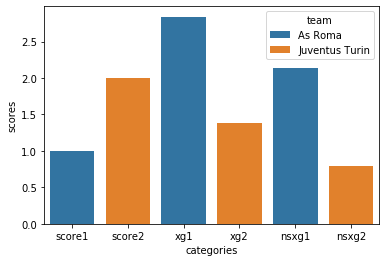

In [23]:
# Creating a bar plot using Seaborn with score, xG, and non-shot values of AS Roma - Juventus:
to_plot = pd.DataFrame({'scores': spi[['score1', 'score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2']].iloc[10194],
                       'categories': ['score1', 'score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2'],
                       'team': ['As Roma', 'Juventus Turin', 'As Roma', 'Juventus Turin', 'As Roma', 'Juventus Turin'],
                       'unit': ['score', 'score', 'xg', 'xg', 'nsxg', 'nsxg']})
sns.barplot(x='categories', y='scores', hue='team', data=to_plot, dodge=False)

In [24]:
# Determining the dependency of the difference between goal_diff and xg_diff on the leading time by linear regression.
# The model is validated by k-fold cross-validation.

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

def xg_lead(frame, lead='ml', xg='xg', mode='diff', neg=True, team_opp=False, cv=3, show=False,
             league=None, season=None, team=None, result=None, match_iloc=None):
    
    if lead == 'win':
        time = 'win_time'
        exception = 'draw'
    elif lead == 'ml':
        time = 'ml_time'
        exception = 'no main leader'
    
    xg_col = f'{xg}_perf_{lead}_{mode}'

    if team:
        cv=10
        if team_opp == True:
            frame = frame[((frame.team1 == team) | (frame.team2 == team)) & (frame.loser == team)]
        else:
            frame = frame[((frame.team1 == team) | (frame.team2 == team)) & (frame[lead] == team)]
    
    if league:
        frame = frame[frame.league == league]
    
    if season:
        frame = frame[frame.season == season] # Some leagues will be excluded.
    
    if result:
        cv = 10
        if lead == 'win' and result[0] == result[1]:
            return ['draw', 'draw']
        frame = frame[((frame.score1 == result[0]) & (frame.score2 == result[1])) | ((frame.score1 == result[1]) & (frame.score2 == result[0]))]

    points = np.array(frame[frame[lead] != exception][[time, xg_col]])
    X = points[:,0]
    y = points[:,1]
    X = X.reshape(-1, 1)
    
    xg_reg = LinearRegression()
    xg_reg.fit(X, y)
    coef = 90 * xg_reg.coef_[0]
    score = cross_val_score(xg_reg, X, y, cv=cv).mean()
    
    if match_iloc:
        return frame[time].iloc[match_iloc], xg_reg.predict([[frame[time].iloc[match_iloc]]])[0]
    
    if show == True:
        y_pred = xg_reg.predict(X)
        if lead == 'win':
            y_pred_select = [[frame[time].mean()], [-90], [-75], [-60], [-45], [-30], [-15], [0], [15], [30], [45], [60], [75], [90]]
        elif lead == 'ml' or neg == False:
            y_pred_select = [[frame[time].mean()], [0], [15], [30], [45], [60], [75], [90]]
        pred_table = pd.DataFrame({'win_lead_min': [y[0] for y in y_pred_select],
                               'goals_xg_diff': [round(y, 2) for y in xg_reg.predict(y_pred_select)]})
        plt.scatter(X, y, alpha = 0.7)
        plt.plot(X, y_pred, color = 'red')
        plt.xlabel(f'minutes {lead} leading minus {lead} behind')
        plt.ylabel(f'goal diff minus {xg} diff')
        plt.title(f'effect of {lead} leading time on {xg} {mode} performance')
        plt.show()
        print(f'The coefficient is {round(coef, 2)} per 90 minutes, the R^2 value is {round(score, 2)}.\n')
        print(pred_table)
    
    return coef, score

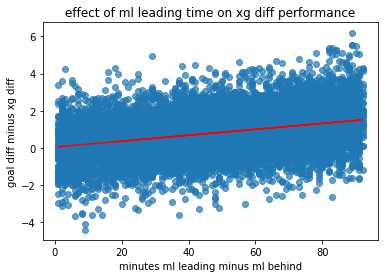

The coefficient is 1.43 per 90 minutes, the R^2 value is 0.12.

   win_lead_min  goals_xg_diff
0     47.744388           0.81
1      0.000000           0.05
2     15.000000           0.28
3     30.000000           0.52
4     45.000000           0.76
5     60.000000           1.00
6     75.000000           1.24
7     90.000000           1.48


(1.432202660978517, 0.11772498222257062)

In [25]:
# Below, some applications of the function are made:
xg_lead(spi, lead='ml', show=True)

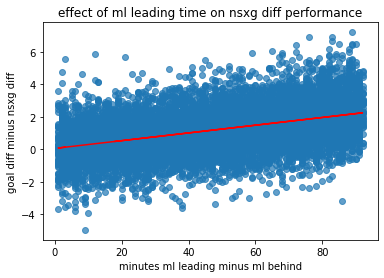

The coefficient is 2.14 per 90 minutes, the R^2 value is 0.19.

   win_lead_min  goals_xg_diff
0     47.744388           1.20
1      0.000000           0.06
2     15.000000           0.42
3     30.000000           0.77
4     45.000000           1.13
5     60.000000           1.49
6     75.000000           1.85
7     90.000000           2.20


(2.142992540898486, 0.19339090572946507)

In [26]:
xg_lead(spi, lead='ml', xg='nsxg', show=True)

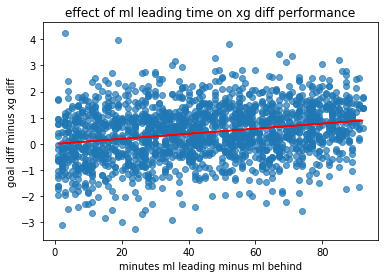

The coefficient is 0.87 per 90 minutes, the R^2 value is 0.05.

   win_lead_min  goals_xg_diff
0     44.259497           0.43
1      0.000000          -0.00
2     15.000000           0.15
3     30.000000           0.29
4     45.000000           0.44
5     60.000000           0.58
6     75.000000           0.73
7     90.000000           0.87


(0.8745247781290698, 0.05040464238070611)

In [27]:
xg_lead(spi, result=(2,1), lead='ml', xg='xg', show=True)

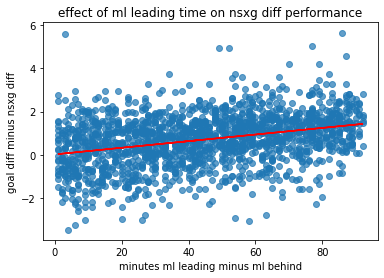

The coefficient is 1.37 per 90 minutes, the R^2 value is 0.1.

   win_lead_min  goals_xg_diff
0     44.259497           0.70
1      0.000000           0.03
2     15.000000           0.26
3     30.000000           0.48
4     45.000000           0.71
5     60.000000           0.94
6     75.000000           1.17
7     90.000000           1.40


(1.3724629274646172, 0.09562034477595467)

In [28]:
xg_lead(spi, result=(2,1), lead='ml', xg='nsxg', show=True)

In [29]:
# Grouping by goal difference shows that the overperformances with respect to xG and non-shot scores increase by goal difference:
spi.groupby('goal_diff_win')[['xg_perf_ml_diff', 'nsxg_perf_ml_diff', 'xg_perf_win_diff', 'nsxg_perf_win_diff']].mean()

,xg_perf_ml_diff,nsxg_perf_ml_diff,xg_perf_win_diff,nsxg_perf_win_diff
goal_diff_win,,,,
1.0,0.511214,0.810407,0.609807,0.951550
2.0,1.111354,1.627340,1.201936,1.745710
3.0,1.689759,2.384952,1.734788,2.450944
4.0,2.292892,3.236471,2.321520,3.270343
5.0,2.637676,3.640915,2.637676,3.640915
6.0,3.256667,4.588810,3.256667,4.588810
7.0,4.037000,5.730000,4.037000,5.730000
8.0,3.640000,5.482500,3.640000,5.482500
9.0,4.000000,5.495000,4.000000,5.495000


In [30]:
# Grouping by the goals of the winner yields a similar result:
spi.groupby('win_goals')[['xg_perf_ml_diff', 'nsxg_perf_ml_diff', 'xg_perf_win_diff', 'nsxg_perf_win_diff']].mean()

,xg_perf_ml_diff,nsxg_perf_ml_diff,xg_perf_win_diff,nsxg_perf_win_diff
win_goals,,,,
1.0,0.629759,0.986585,0.629759,0.986585
2.0,0.764929,1.167691,0.862738,1.300471
3.0,1.103630,1.594451,1.230864,1.772049
4.0,1.598113,2.280170,1.731034,2.462723
5.0,2.229315,3.006918,2.294521,3.135959
6.0,2.866190,3.901071,2.866190,3.901071
7.0,3.234737,4.658421,3.234737,4.658421
8.0,3.646250,5.202500,3.646250,5.202500
9.0,4.000000,5.495000,4.000000,5.495000


In [31]:
# Showing some correlations:
spi[['ml_time', 'goal_diff_ml', 'goals_total', 'win_goals', 'xg_perf_ml_diff', 'nsxg_perf_ml_diff', ]].corr()

# There is a meaningful correlation between xG and non-shot diff performances and goal difference,
# but also between goal difference and leading time. Goal difference is a confounding variable.

,ml_time,goal_diff_ml,goals_total,win_goals,xg_perf_ml_diff,nsxg_perf_ml_diff
ml_time,1.000000,0.461838,0.176469,0.295665,0.343537,0.440235
goal_diff_ml,0.461838,1.000000,0.240048,0.580923,0.598053,0.712178
goals_total,0.176469,0.240048,1.000000,0.916923,0.158365,0.166971
win_goals,0.295665,0.580923,0.916923,1.000000,0.354781,0.399464
xg_perf_ml_diff,0.343537,0.598053,0.158365,0.354781,1.000000,0.766177
nsxg_perf_ml_diff,0.440235,0.712178,0.166971,0.399464,0.766177,1.000000


In [32]:
# Calculating std and correlations with respect to leading time groups:
def assign_time_group(time_list):
    group_list = []
    for time in time_list:
        if time <= 15:
            group_list.append('A')
        elif time <= 30:
            group_list.append('B')
        elif time <= 45:
            group_list.append('C')
        elif time <= 60:
            group_list.append('D')
        elif time <= 75:
            group_list.append('E')
        elif time:
            group_list.append('F')
        else:
            group_list.append(None)
    return group_list

spi['ml_time_group'] = assign_time_group(spi.ml_time)

two_one = spi[((spi.score1 == 2) & (spi.score2 == 1)) | ((spi.score1 == 1) & (spi.score2 == 2))]

print(round(spi.groupby('ml_time_group').xg_perf_ml_diff.std(), 2))
print(round(spi.groupby('ml_time_group').nsxg_perf_ml_diff.std(), 2))
print(round(two_one.groupby('ml_time_group').xg_perf_ml_diff.std(), 2))
print(round(two_one.groupby('ml_time_group').nsxg_perf_ml_diff.std(), 2))

print(round(spi.groupby('ml_time_group')[['ml_time', 'xg_perf_ml_diff', 'nsxg_perf_ml_diff']].corr(), 2))
print(round(two_one.groupby('ml_time_group')[['ml_time', 'xg_perf_ml_diff', 'nsxg_perf_ml_diff']].corr(), 2))

# There is no meaningful difference among time groups.

ml_time_group
A    1.13
B    1.09
C    1.11
D    1.13
E    1.15
F    1.22
Name: xg_perf_ml_diff, dtype: float64
ml_time_group
A    1.25
B    1.22
C    1.24
D    1.27
E    1.29
F    1.35
Name: nsxg_perf_ml_diff, dtype: float64
ml_time_group
A    1.09
B    1.10
C    0.96
D    0.97
E    1.02
F    0.88
Name: xg_perf_ml_diff, dtype: float64
ml_time_group
A    1.27
B    1.15
C    0.99
D    1.14
E    1.06
F    1.04
Name: nsxg_perf_ml_diff, dtype: float64
                                 ml_time  xg_perf_ml_diff  nsxg_perf_ml_diff
ml_time_group                                                               
A             ml_time               1.00             0.06               0.10
              xg_perf_ml_diff       0.06             1.00               0.73
              nsxg_perf_ml_diff     0.10             0.73               1.00
B             ml_time               1.00             0.02               0.04
              xg_perf_ml_diff       0.02             1.00               0.73
         

In [33]:
# Calculating the ratio of teams who underperform or who overperform by a wider margin than Juve:
print(round(two_one[two_one.xg_perf_ml_diff < 0].score1.count() / two_one.score1.count(), 2))
print(round(two_one[two_one.xg_perf_ml_diff > 2.46].score1.count() / two_one.score1.count(), 2))
print(round(two_one[two_one.nsxg_perf_ml_diff < 0].score1.count() / two_one.score1.count(), 2))
print(round(two_one[two_one.nsxg_perf_ml_diff > 2.34].score1.count() / two_one.score1.count(), 2))

0.32
0.02
0.25
0.06


In [34]:
# Function that gets some statistics for a column:
def stats(col):
    vals = n[1][col]
    return vals.mean(), vals.std(), vals.quantile(0.05), vals.quantile(0.95)

In [35]:
# Creating a data frame that groups regressions and other statistics by match result, using xg_lead.
# Some of the columns are experimental:
score_list = []
for n in spi.groupby(['score1', 'score2']):
    result_n = n[0]
    amount_n = n[1].date.count()
    if result_n == (0, 0):
        continue
    if not result_n[0] == result_n[1]:
        for o in spi.groupby(['score1', 'score2']):
            result_o = o[0]
            amount_o = o[1].date.count()
            if result_o == (result_n[1], result_n[0]):
                amount_n += amount_o
                break
    if result_n[0] < result_n[1]:
        if (result_n[1], result_n[0]) in spi.groupby(['score1', 'score2']).groups:
            continue
    if amount_n >= 20:
        score_list.append([*result_n, amount_n,
                           n[1].ml_time.mean(), n[1].ml_time.std(),
                           *stats('xg_perf_ml_diff'),
                           *xg_lead(spi, result=result_n, mode='diff', xg='xg', lead='ml'),
                           *stats('xg_perf_ml_own'),
                           *xg_lead(spi, result=result_n, mode='own', xg='xg', lead='ml'),
                           *stats('xg_perf_ml_opp'),
                           *xg_lead(spi, result=result_n, mode='opp', xg='xg', lead='ml'),
                           *stats('nsxg_perf_ml_diff'),
                           *xg_lead(spi, result=result_n, mode='diff', xg='nsxg', lead='ml'),
                           *stats('nsxg_perf_ml_own'),
                           *xg_lead(spi, result=result_n, mode='own', xg='nsxg', lead='ml'),
                           *stats('nsxg_perf_ml_opp'),
                           *xg_lead(spi, result=result_n, mode='opp', xg='nsxg', lead='ml'),
                           *stats('ms_perf_ml_diff'),
                           *xg_lead(spi, result=result_n, mode='diff', xg='ms', lead='ml'),
                           *stats('ms_perf_ml_own'),
                           *xg_lead(spi, result=result_n, mode='own', xg='ms', lead='ml'),
                           *stats('ms_perf_ml_opp'),
                           *xg_lead(spi, result=result_n, mode='opp', xg='ms', lead='ml'),
                           n[1].win_time.mean(), n[1].win_time.std(),
                           *stats('xg_perf_win_diff'),
                           *xg_lead(spi, result=result_n, mode='diff', xg='xg', lead='win'),
                           *stats('xg_perf_win_own'),
                           *xg_lead(spi, result=result_n, mode='own', xg='xg', lead='win'),
                           *stats('xg_perf_win_opp'),
                           *xg_lead(spi, result=result_n, mode='opp', xg='xg', lead='win'),
                           *stats('nsxg_perf_win_diff'),
                           *xg_lead(spi, result=result_n, mode='diff', xg='nsxg', lead='win'),
                           *stats('nsxg_perf_win_own'),
                           *xg_lead(spi, result=result_n, mode='own', xg='nsxg', lead='win'),
                           *stats('nsxg_perf_win_opp'),
                           *xg_lead(spi, result=result_n, mode='opp', xg='nsxg', lead='win'),
                           *stats('ms_perf_win_diff'),
                           *xg_lead(spi, result=result_n, mode='diff', xg='ms', lead='win'),
                           *stats('ms_perf_win_own'),
                           *xg_lead(spi, result=result_n, mode='own', xg='ms', lead='win'),
                           *stats('ms_perf_win_opp'),
                           *xg_lead(spi, result=result_n, mode='opp', xg='ms', lead='win')])
        
results = pd.DataFrame(score_list, columns=['score1', 'score2', 'num_matches',
                                            'time_ml_avg', 'time_ml_std',
                                            'xg_perf_ml_diff', 'xg_perf_ml_diff_std',
                                            'xg_perf_ml_diff_lower', 'xg_perf_ml_diff_upper',
                                            'xg_perf_ml_diff_coef', 'xg_perf_ml_diff_r2',
                                            'xg_perf_ml_own', 'xg_perf_ml_own_std',
                                            'xg_perf_ml_own_lower', 'xg_perf_ml_own_upper',
                                            'xg_perf_ml_own_coef', 'xg_perf_ml_own_r2',
                                            'xg_perf_ml_opp', 'xg_perf_ml_opp_std',
                                            'xg_perf_ml_opp_lower', 'xg_perf_ml_opp_upper',
                                            'xg_perf_ml_opp_coef', 'xg_perf_ml_opp_r2',
                                            'nsxg_perf_ml_diff', 'nsxg_perf_ml_diff_std',
                                            'nsxg_perf_ml_diff_lower', 'nsxg_perf_ml_diff_upper',
                                            'nsxg_perf_ml_diff_coef', 'nsxg_perf_ml_diff_r2',
                                            'nsxg_perf_ml_own', 'nsxg_perf_ml_own_std',
                                            'nsxg_perf_ml_own_lower', 'nsxg_perf_ml_own_upper',
                                            'nsxg_perf_ml_own_coef', 'nsxg_perf_ml_own_r2',
                                            'nsxg_perf_ml_opp', 'nsxg_perf_ml_opp_std',
                                            'nsxg_perf_ml_opp_lower', 'nsxg_perf_ml_opp_upper',
                                            'nsxg_perf_ml_opp_coef', 'nsxg_perf_ml_opp_r2',
                                            'ms_perf_ml_diff', 'ms_perf_ml_diff_std',
                                            'ms_perf_ml_diff_lower', 'ms_perf_ml_diff_upper',
                                            'ms_perf_ml_diff_coef', 'ms_perf_ml_diff_r2',
                                            'ms_perf_ml_own', 'ms_perf_ml_own_std',
                                            'ms_perf_ml_own_lower', 'ms_perf_ml_own_upper',
                                            'ms_perf_ml_own_coef', 'ms_perf_ml_own_r2',
                                            'ms_perf_ml_opp', 'ms_perf_ml_opp_std',
                                            'ms_perf_ml_opp_lower', 'ms_perf_ml_opp_upper',
                                            'ms_perf_ml_opp_coef', 'ms_perf_ml_opp_r2',
                                            'time_win_avg', 'time_win_std',
                                            'xg_perf_win_diff', 'xg_perf_win_diff_std',
                                            'xg_perf_win_diff_lower', 'xg_perf_win_diff_upper',
                                            'xg_perf_win_diff_coef', 'xg_perf_win_diff_r2',
                                            'xg_perf_win_own', 'xg_perf_win_own_std',
                                            'xg_perf_win_own_lower', 'xg_perf_win_own_upper',
                                            'xg_perf_win_own_coef', 'xg_perf_win_own_r2',
                                            'xg_perf_win_opp', 'xg_perf_win_opp_std',
                                            'xg_perf_win_opp_lower', 'xg_perf_win_opp_upper',
                                            'xg_perf_win_opp_coef', 'xg_perf_win_opp_r2',
                                            'nsxg_perf_win_diff', 'nsxg_perf_win_diff_std',
                                            'nsxg_perf_win_diff_lower', 'nsxg_perf_win_diff_upper',
                                            'nsxg_perf_win_diff_coef', 'nsxg_perf_win_diff_r2',
                                            'nsxg_perf_win_own', 'nsxg_perf_win_own_std',
                                            'nsxg_perf_win_own_lower', 'nsxg_perf_win_own_upper',
                                            'nsxg_perf_win_own_coef', 'nsxg_perf_win_own_r2',
                                            'nsxg_perf_win_opp', 'nsxg_perf_win_opp_std',
                                            'nsxg_perf_win_opp_lower', 'nsxg_perf_win_opp_upper',
                                            'nsxg_perf_win_opp_coef', 'nsxg_perf_win_opp_r2',
                                            'ms_perf_win_diff', 'ms_perf_win_diff_std',
                                            'ms_perf_win_diff_lower', 'ms_perf_win_diff_upper',
                                            'ms_perf_win_diff_coef', 'ms_perf_win_diff_r2',
                                            'ms_perf_win_own', 'ms_perf_win_own_std',
                                            'ms_perf_win_own_lower', 'ms_perf_win_own_upper',
                                            'ms_perf_win_own_coef', 'ms_perf_win_own_r2',
                                            'ms_perf_win_opp', 'ms_perf_win_opp_std',
                                            'ms_perf_win_opp_lower', 'ms_perf_win_opp_upper',
                                            'ms_perf_win_opp_coef', 'ms_perf_win_opp_r2'])

results.replace({'draw': None, 'teams': None}, inplace=True)
results['goals_total'] = results.score1 + results.score2
results['goals_diff'] = abs(results.score1 - results.score2)

In [36]:
# Selected columns of the results frame are displayed:
results[['score1', 'score2', 'num_matches', 'time_ml_avg', 'time_ml_std',
         'xg_perf_ml_diff', 'xg_perf_ml_diff_std', 'xg_perf_ml_diff_lower', 'xg_perf_ml_diff_upper', 'xg_perf_ml_diff_coef',
         'nsxg_perf_ml_diff', 'nsxg_perf_ml_diff_std', 'nsxg_perf_ml_diff_lower', 'nsxg_perf_ml_diff_upper', 'nsxg_perf_ml_diff_coef']]

,score1,score2,num_matches,time_ml_avg,time_ml_std,xg_perf_ml_diff,xg_perf_ml_diff_std,xg_perf_ml_diff_lower,xg_perf_ml_diff_upper,xg_perf_ml_diff_coef,nsxg_perf_ml_diff,nsxg_perf_ml_diff_std,nsxg_perf_ml_diff_lower,nsxg_perf_ml_diff_upper,nsxg_perf_ml_diff_coef
0,1,0,1912,41.195166,26.029681,0.478827,0.887791,-0.9900,1.9000,0.305850,0.813805,0.912967,-0.6320,2.3620,0.765937
1,1,1,1321,32.578907,21.346818,0.123991,0.918542,-1.3315,1.6200,0.486017,0.208892,0.992700,-1.3800,1.7900,0.838378
2,2,0,1312,57.211217,22.233195,1.094248,0.927962,-0.4715,2.4815,0.358011,1.636456,0.974809,0.1200,3.1745,0.778069
3,2,1,1723,44.252525,25.524723,0.372283,0.998213,-1.3100,1.9655,0.874525,0.615343,1.070730,-1.2055,2.1455,1.372463
4,2,2,577,39.287456,23.064806,0.061115,1.059630,-1.5470,1.7635,0.523575,0.205732,1.029171,-1.4135,1.8240,0.911068
5,3,0,722,64.566946,19.440246,1.611883,0.935096,0.0485,3.0100,0.388424,2.338243,0.939962,0.6500,3.7130,0.667694
6,3,1,783,52.612500,24.894094,0.896646,1.158151,-1.0240,2.6935,1.277926,1.296354,1.258365,-1.1600,3.0915,1.856646
7,3,2,486,45.088968,25.877926,0.346192,1.038585,-1.2700,1.8200,0.694033,0.541708,1.052483,-1.4100,2.1700,1.165346
8,3,3,111,40.729730,24.543818,0.153063,1.080763,-1.4950,1.8100,0.283447,0.178288,0.954437,-1.3450,1.7050,0.652589
9,4,0,286,71.294737,15.440875,2.138316,1.069960,0.5425,3.7410,0.736671,3.211526,0.918210,1.7445,4.7230,0.411339


In [37]:
# Calculates the weighted average of selected columns (weighted by number of matches):
from statsmodels.stats.weightstats import DescrStatsW

weighted = {}

for col in results.columns:
    if col in ['score1', 'score2', 'num_matches'] or 'lower' in col or 'upper' in col or 'r2' in col:
        continue
    frame = results[results[col].notnull()][[col, 'num_matches']]
    mod = DescrStatsW(frame[col], weights = frame.num_matches)
    weighted[col] = mod.mean

weighted

# The regression coefficients for xG and non-shot of the main leader are 0.72 and 1.09 goals per 90 minutes.

{'time_ml_avg': 47.871451264532205,
 'time_ml_std': 23.493326897845908,
 'xg_perf_ml_diff': 0.7180645442382705,
 'xg_perf_ml_diff_std': 0.9879955950006096,
 'xg_perf_ml_diff_coef': 0.6337756539162093,
 'xg_perf_ml_own': 0.43669676522697065,
 'xg_perf_ml_own_std': 0.7220788420193778,
 'xg_perf_ml_own_coef': 0.32574988737612687,
 'xg_perf_ml_opp': -0.2813677790112999,
 'xg_perf_ml_opp_std': 0.5829304201403116,
 'xg_perf_ml_opp_coef': -0.30802576654008246,
 'nsxg_perf_ml_diff': 1.087569861511958,
 'nsxg_perf_ml_diff_std': 1.0269196113404373,
 'nsxg_perf_ml_diff_coef': 1.0506907176291362,
 'nsxg_perf_ml_own': 0.6993549220785311,
 'nsxg_perf_ml_own_std': 0.651178031942159,
 'nsxg_perf_ml_own_coef': 0.5204043035928072,
 'nsxg_perf_ml_opp': -0.38821493943342683,
 'nsxg_perf_ml_opp_std': 0.5921254792039297,
 'nsxg_perf_ml_opp_coef': -0.530286414036329,
 'ms_perf_ml_diff': 0.6148152912808141,
 'ms_perf_ml_diff_std': 0.6078671658359903,
 'ms_perf_ml_diff_coef': 0.5185265421206864,
 'ms_perf_ml_o

In [39]:
corr_mod = DescrStatsW(results[['xg_perf_ml_diff_coef', 'nsxg_perf_ml_diff_coef', 'time_ml_avg',
                                'goals_total', 'goals_diff']],
                       weights=[[results.num_matches]])
for c in corr_mod.corrcoef:
    print(c)

[1.         0.90818149 0.19398924 0.64212812 0.2462132 ]
[0.90818149 1.         0.01591247 0.54061033 0.0483154 ]
[0.19398924 0.01591247 1.         0.38692809 0.96519963]
[0.64212812 0.54061033 0.38692809 1.         0.36386643]
[0.2462132  0.0483154  0.96519963 0.36386643 1.        ]


In [38]:
# Determining the dependency of the leading time on the difference between goal_diff and xg_diff by linear regression.
# The model is validated by k-fold cross-validation. The function is basically the reverse of xg_lead.

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

def xg_reverse(frame, lead='ml', xg='xg', mode='diff', neg=True, team_opp=False, cv=3, show=False,
             league=None, season=None, team=None, result=None):
    
    if lead == 'win':
        time = 'win_time'
        exception = 'draw'
    elif lead == 'ml':
        time = 'ml_time'
        exception = 'no main leader'
    
    xg_col = f'{xg}_perf_{lead}_{mode}'

    if team:
        cv=10
        if team_opp == True:
            frame = frame[((frame.team1 == team) | (frame.team2 == team)) & (frame.loser == team)]
        else:
            frame = frame[((frame.team1 == team) | (frame.team2 == team)) & (frame[lead] == team)]
    
    if league:
        frame = frame[frame.league == league]
    
    if season:
        frame = frame[frame.season == season] # Some leagues will be excluded.
    
    if result:
        cv = 10
        if lead == 'win' and result[0] == result[1]:
            return ['draw', 'draw']
        frame = frame[((frame.score1 == result[0]) & (frame.score2 == result[1])) | ((frame.score1 == result[1]) & (frame.score2 == result[0]))]

    points = np.array(frame[frame[lead] != exception][[time, xg_col]])
    X = points[:,1]
    y = points[:,0]
    X = X.reshape(-1, 1)
    
    xg_reg = LinearRegression()
    xg_reg.fit(X, y)
    coef = xg_reg.coef_[0]
    score = cross_val_score(xg_reg, X, y, cv=cv).mean()
    
    if show == True:
        y_pred = xg_reg.predict(X)
        y_pred_select = [[-4], [-3], [-2], [-1.5], [-1], [-0.5], [0], [0.5], [1], [1.5], [2], [3], [4]]
        pred_table = pd.DataFrame({'goals_xg_diff': [y[0] for y in y_pred_select],
                               'win_lead_min': [round(y, 2) for y in xg_reg.predict(y_pred_select)]})
        plt.scatter(X, y, alpha = 0.7)
        plt.plot(X, y_pred, color = 'red')
        plt.xlabel(f'goal diff minus {xg} diff')
        plt.ylabel(f'minutes {lead} leading minus {lead} behind')
        plt.title([lead, xg, mode])
        plt.show()
        print(f'The coefficient is {round(coef, 2)} minutes per 1 goal, the R^2 value is {round(score, 2)}.\n')
        print(pred_table)
    
    return coef, score

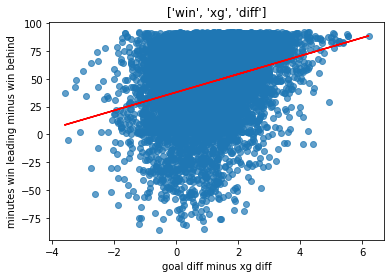

The coefficient is 8.18 minutes per 1 goal, the R^2 value is 0.08.

    goals_xg_diff  win_lead_min
0            -4.0          5.21
1            -3.0         13.39
2            -2.0         21.58
3            -1.5         25.67
4            -1.0         29.76
5            -0.5         33.85
6             0.0         37.94
7             0.5         42.04
8             1.0         46.13
9             1.5         50.22
10            2.0         54.31
11            3.0         62.49
12            4.0         70.68


(8.183225238219565, 0.0770411582217458)

In [39]:
# Below, some applications of xg_reverse are displayed:
xg_reverse(spi, lead='win', show=True)

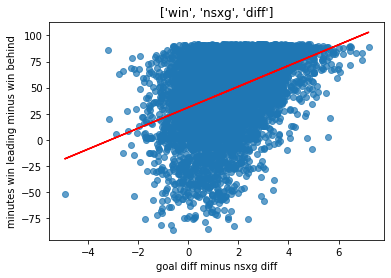

The coefficient is 9.99 minutes per 1 goal, the R^2 value is 0.14.

    goals_xg_diff  win_lead_min
0            -4.0         -8.87
1            -3.0          1.12
2            -2.0         11.10
3            -1.5         16.10
4            -1.0         21.09
5            -0.5         26.08
6             0.0         31.08
7             0.5         36.07
8             1.0         41.06
9             1.5         46.05
10            2.0         51.05
11            3.0         61.03
12            4.0         71.02


(9.986192314153557, 0.1444760646937182)

In [40]:
xg_reverse(spi, lead='win', xg='nsxg', show=True)

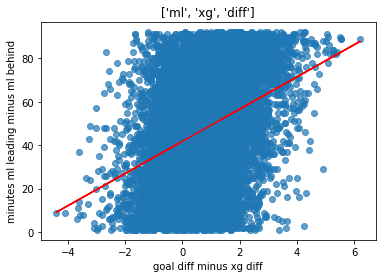

The coefficient is 7.42 minutes per 1 goal, the R^2 value is 0.12.

    goals_xg_diff  win_lead_min
0            -4.0         12.10
1            -3.0         19.52
2            -2.0         26.94
3            -1.5         30.65
4            -1.0         34.35
5            -0.5         38.06
6             0.0         41.77
7             0.5         45.48
8             1.0         49.19
9             1.5         52.89
10            2.0         56.60
11            3.0         64.02
12            4.0         71.43


(7.416277596452761, 0.11735573586930685)

In [41]:
xg_reverse(spi, show=True)

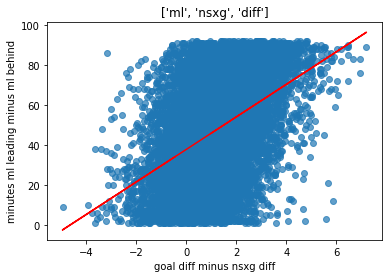

The coefficient is 8.14 minutes per 1 goal, the R^2 value is 0.19.

    goals_xg_diff  win_lead_min
0            -4.0          5.45
1            -3.0         13.59
2            -2.0         21.73
3            -1.5         25.80
4            -1.0         29.87
5            -0.5         33.94
6             0.0         38.01
7             0.5         42.08
8             1.0         46.15
9             1.5         50.22
10            2.0         54.29
11            3.0         62.43
12            4.0         70.57


(8.139375884196525, 0.1930212029691225)

In [42]:
xg_reverse(spi, xg='nsxg', show=True)

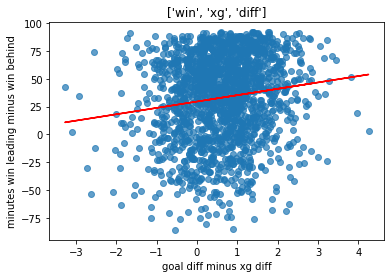

The coefficient is 5.74 minutes per 1 goal, the R^2 value is 0.01.

    goals_xg_diff  win_lead_min
0            -4.0          6.64
1            -3.0         12.38
2            -2.0         18.12
3            -1.5         20.99
4            -1.0         23.86
5            -0.5         26.73
6             0.0         29.60
7             0.5         32.47
8             1.0         35.34
9             1.5         38.21
10            2.0         41.08
11            3.0         46.81
12            4.0         52.55


(5.7387789065528585, 0.01213216468027839)

In [43]:
xg_reverse(spi, result=(2,1), lead='win', show=True)

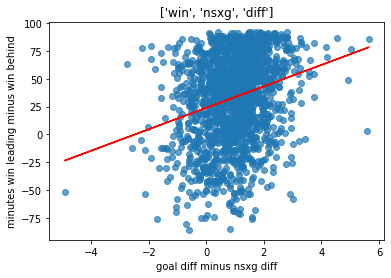

The coefficient is 9.66 minutes per 1 goal, the R^2 value is 0.06.

    goals_xg_diff  win_lead_min
0            -4.0        -14.63
1            -3.0         -4.97
2            -2.0          4.68
3            -1.5          9.51
4            -1.0         14.34
5            -0.5         19.17
6             0.0         24.00
7             0.5         28.83
8             1.0         33.66
9             1.5         38.48
10            2.0         43.31
11            3.0         52.97
12            4.0         62.63


(9.65702838688881, 0.055694051420060266)

In [44]:
xg_reverse(spi, result=(2,1), lead='win', xg='nsxg', show=True)

In [45]:
# Creating a data frame that groups regressions and other statistics by match result, using xg_reverse.
# Some of the columns are experimental:
score_list = []
for n in spi.groupby(['score1', 'score2']):
    result_n = n[0]
    amount_n = n[1].date.count()
    if result_n == (0, 0):
        continue
    if not result_n[0] == result_n[1]:
        for o in spi.groupby(['score1', 'score2']):
            result_o = o[0]
            amount_o = o[1].date.count()
            if result_o == (result_n[1], result_n[0]):
                amount_n += amount_o
                break
    if result_n[0] < result_n[1]:
        if (result_n[1], result_n[0]) in spi.groupby(['score1', 'score2']).groups:
            continue
    if amount_n >= 20:
        score_list.append([*result_n, amount_n,
                           n[1].ml_time.mean(), n[1].ml_time.std(),
                           *stats('xg_perf_ml_diff'),
                           *xg_reverse(spi, result=result_n, mode='diff', xg='xg', lead='ml'),
                           *stats('xg_perf_ml_own'),
                           *xg_reverse(spi, result=result_n, mode='own', xg='xg', lead='ml'),
                           *stats('xg_perf_ml_opp'),
                           *xg_reverse(spi, result=result_n, mode='opp', xg='xg', lead='ml'),
                           *stats('nsxg_perf_ml_diff'),
                           *xg_reverse(spi, result=result_n, mode='diff', xg='nsxg', lead='ml'),
                           *stats('nsxg_perf_ml_own'),
                           *xg_reverse(spi, result=result_n, mode='own', xg='nsxg', lead='ml'),
                           *stats('nsxg_perf_ml_opp'),
                           *xg_reverse(spi, result=result_n, mode='opp', xg='nsxg', lead='ml'),
                           *stats('ms_perf_ml_diff'),
                           *xg_reverse(spi, result=result_n, mode='diff', xg='ms', lead='ml'),
                           *stats('ms_perf_ml_own'),
                           *xg_reverse(spi, result=result_n, mode='own', xg='ms', lead='ml'),
                           *stats('ms_perf_ml_opp'),
                           *xg_reverse(spi, result=result_n, mode='opp', xg='ms', lead='ml'),
                           n[1].win_time.mean(), n[1].win_time.std(),
                           *stats('xg_perf_win_diff'),
                           *xg_reverse(spi, result=result_n, mode='diff', xg='xg', lead='win'),
                           *stats('xg_perf_win_own'),
                           *xg_reverse(spi, result=result_n, mode='own', xg='xg', lead='win'),
                           *stats('xg_perf_win_opp'),
                           *xg_reverse(spi, result=result_n, mode='opp', xg='xg', lead='win'),
                           *stats('nsxg_perf_win_diff'),
                           *xg_reverse(spi, result=result_n, mode='diff', xg='nsxg', lead='win'),
                           *stats('nsxg_perf_win_own'),
                           *xg_reverse(spi, result=result_n, mode='own', xg='nsxg', lead='win'),
                           *stats('nsxg_perf_win_opp'),
                           *xg_reverse(spi, result=result_n, mode='opp', xg='nsxg', lead='win'),
                           *stats('ms_perf_win_diff'),
                           *xg_reverse(spi, result=result_n, mode='diff', xg='ms', lead='win'),
                           *stats('ms_perf_win_own'),
                           *xg_reverse(spi, result=result_n, mode='own', xg='ms', lead='win'),
                           *stats('ms_perf_win_opp'),
                           *xg_reverse(spi, result=result_n, mode='opp', xg='ms', lead='win')])
        
res_rev = pd.DataFrame(score_list, columns=['score1', 'score2', 'num_matches',
                                            'time_ml', 'time_ml_std',
                                            'xg_perf_ml_diff', 'xg_perf_ml_diff_std',
                                            'xg_perf_ml_diff_lower', 'xg_perf_ml_diff_upper',
                                            'xg_perf_ml_diff_coef', 'xg_perf_ml_diff_r2',
                                            'xg_perf_ml_own', 'xg_perf_ml_own_std',
                                            'xg_perf_ml_own_lower', 'xg_perf_ml_own_upper',
                                            'xg_perf_ml_own_coef', 'xg_perf_ml_own_r2',
                                            'xg_perf_ml_opp', 'xg_perf_ml_opp_std',
                                            'xg_perf_ml_opp_lower', 'xg_perf_ml_opp_upper',
                                            'xg_perf_ml_opp_coef', 'xg_perf_ml_opp_r2',
                                            'nsxg_perf_ml_diff', 'nsxg_perf_ml_diff_std',
                                            'nsxg_perf_ml_diff_lower', 'nsxg_perf_ml_diff_upper',
                                            'nsxg_perf_ml_diff_coef', 'nsxg_perf_ml_diff_r2',
                                            'nsxg_perf_ml_own', 'nsxg_perf_ml_own_std',
                                            'nsxg_perf_ml_own_lower', 'nsxg_perf_ml_own_upper',
                                            'nsxg_perf_ml_own_coef', 'nsxg_perf_ml_own_r2',
                                            'nsxg_perf_ml_opp', 'nsxg_perf_ml_opp_std',
                                            'nsxg_perf_ml_opp_lower', 'nsxg_perf_ml_opp_upper',
                                            'nsxg_perf_ml_opp_coef', 'nsxg_perf_ml_opp_r2',
                                            'ms_perf_ml_diff', 'ms_perf_ml_diff_std',
                                            'ms_perf_ml_diff_lower', 'ms_perf_ml_diff_upper',
                                            'ms_perf_ml_diff_coef', 'ms_perf_ml_diff_r2',
                                            'ms_perf_ml_own', 'ms_perf_ml_own_std',
                                            'ms_perf_ml_own_lower', 'ms_perf_ml_own_upper',
                                            'ms_perf_ml_own_coef', 'ms_perf_ml_own_r2',
                                            'ms_perf_ml_opp', 'ms_perf_ml_opp_std',
                                            'ms_perf_ml_opp_lower', 'ms_perf_ml_opp_upper',
                                            'ms_perf_ml_opp_coef', 'ms_perf_ml_opp_r2',
                                            'time_win', 'time_win_std',
                                            'xg_perf_win_diff', 'xg_perf_win_diff_std',
                                            'xg_perf_win_diff_lower', 'xg_perf_win_diff_upper',
                                            'xg_perf_win_diff_coef', 'xg_perf_win_diff_r2',
                                            'xg_perf_win_own', 'xg_perf_win_own_std',
                                            'xg_perf_win_own_lower', 'xg_perf_win_own_upper',
                                            'xg_perf_win_own_coef', 'xg_perf_win_own_r2',
                                            'xg_perf_win_opp', 'xg_perf_win_opp_std',
                                            'xg_perf_win_opp_lower', 'xg_perf_win_opp_upper',
                                            'xg_perf_win_opp_coef', 'xg_perf_win_opp_r2',
                                            'nsxg_perf_win_diff', 'nsxg_perf_win_diff_std',
                                            'nsxg_perf_win_diff_lower', 'nsxg_perf_win_diff_upper',
                                            'nsxg_perf_win_diff_coef', 'nsxg_perf_win_diff_r2',
                                            'nsxg_perf_win_own', 'nsxg_perf_win_own_std',
                                            'nsxg_perf_win_own_lower', 'nsxg_perf_win_own_upper',
                                            'nsxg_perf_win_own_coef', 'nsxg_perf_win_own_r2',
                                            'nsxg_perf_win_opp', 'nsxg_perf_win_opp_std',
                                            'nsxg_perf_win_opp_lower', 'nsxg_perf_win_opp_upper',
                                            'nsxg_perf_win_opp_coef', 'nsxg_perf_win_opp_r2',
                                            'ms_perf_win_diff', 'ms_perf_win_diff_std',
                                            'ms_perf_win_diff_lower', 'ms_perf_win_diff_upper',
                                            'ms_perf_win_diff_coef', 'ms_perf_win_diff_r2',
                                            'ms_perf_win_own', 'ms_perf_win_own_std',
                                            'ms_perf_win_own_lower', 'ms_perf_win_own_upper',
                                            'ms_perf_win_own_coef', 'ms_perf_win_own_r2',
                                            'ms_perf_win_opp', 'ms_perf_win_opp_std',
                                            'ms_perf_win_opp_lower', 'ms_perf_win_opp_upper',
                                            'ms_perf_win_opp_coef', 'ms_perf_win_opp_r2'])

res_rev.replace({'draw': None, 'teams': None}, inplace=True)
res_rev['goals_total'] = res_rev.score1 + res_rev.score2
res_rev['goals_diff'] = abs(res_rev.score1 - res_rev.score2)

In [46]:
# Displays selected columns of the data frame:
res_rev[['score1', 'score2', 'num_matches',
         'xg_perf_win_diff', 'xg_perf_win_diff_std', 'xg_perf_win_diff_lower', 'xg_perf_win_diff_upper', 'xg_perf_win_diff_coef',
         'nsxg_perf_win_diff', 'nsxg_perf_win_diff_std', 'nsxg_perf_win_diff_lower', 'nsxg_perf_win_diff_upper', 'nsxg_perf_win_diff_coef']]

,score1,score2,num_matches,xg_perf_win_diff,xg_perf_win_diff_std,xg_perf_win_diff_lower,xg_perf_win_diff_upper,xg_perf_win_diff_coef,nsxg_perf_win_diff,nsxg_perf_win_diff_std,nsxg_perf_win_diff_lower,nsxg_perf_win_diff_upper,nsxg_perf_win_diff_coef
0,1,0,1912,0.478827,0.887791,-0.9900,1.9000,2.841008,0.813805,0.912967,-0.6320,2.3620,6.136024
1,1,1,1321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,1312,1.094248,0.927962,-0.4715,2.4815,2.250497,1.636456,0.974809,0.1200,3.1745,4.271351
3,2,1,1723,0.471022,0.954364,-1.0600,1.9930,5.738779,0.763707,0.967688,-0.8900,2.2530,9.657028
4,2,2,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3,0,722,1.611883,0.935096,0.0485,3.0100,1.782800,2.338243,0.939962,0.6500,3.7130,2.879643
6,3,1,783,1.046687,1.024268,-0.5705,2.7810,3.676562,1.508354,0.993802,-0.2505,3.1200,6.947820
7,3,2,486,0.433497,1.011813,-1.1500,1.8200,5.103914,0.738147,0.921362,-0.9250,2.1700,9.784783
8,3,3,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4,0,286,2.138316,1.069960,0.5425,3.7410,1.911065,3.211526,0.918210,1.7445,4.7230,1.220416


In [47]:
# Calculates the weighted average of selected columns (weighted by number of matches):
from statsmodels.stats.weightstats import DescrStatsW

weighted = {}

for col in res_rev.columns:
    if col in ['score1', 'score2', 'num_matches'] or 'lower' in col or 'upper' in col or 'r2' in col:
        continue
    frame = res_rev[res_rev[col].notnull()][[col, 'num_matches']]
    mod = DescrStatsW(frame[col], weights = frame.num_matches)
    weighted[col] = mod.mean

weighted

# The regression coefficients for xG and non-shot of the winner are 3.42 and 6.24 minutes per goal (not time format).

{'time_ml': 47.871451264532205,
 'time_ml_std': 23.493326897845908,
 'xg_perf_ml_diff': 0.7180645442382705,
 'xg_perf_ml_diff_std': 0.9879955950006096,
 'xg_perf_ml_diff_coef': 3.632559609929789,
 'xg_perf_ml_own': 0.43669676522697065,
 'xg_perf_ml_own_std': 0.7220788420193778,
 'xg_perf_ml_own_coef': 3.7288059261135644,
 'xg_perf_ml_opp': -0.2813677790112999,
 'xg_perf_ml_opp_std': 0.5829304201403116,
 'xg_perf_ml_opp_coef': -4.751293823525279,
 'nsxg_perf_ml_diff': 1.087569861511958,
 'nsxg_perf_ml_diff_std': 1.0269196113404373,
 'nsxg_perf_ml_diff_coef': 5.432186960223901,
 'nsxg_perf_ml_own': 0.6993549220785311,
 'nsxg_perf_ml_own_std': 0.651178031942159,
 'nsxg_perf_ml_own_coef': 7.43715364160671,
 'nsxg_perf_ml_opp': -0.38821493943342683,
 'nsxg_perf_ml_opp_std': 0.5921254792039297,
 'nsxg_perf_ml_opp_coef': -7.916376064151857,
 'ms_perf_ml_diff': 0.6148152912808141,
 'ms_perf_ml_diff_std': 0.6078671658359903,
 'ms_perf_ml_diff_coef': 7.666915285499725,
 'ms_perf_ml_own': 0.38225

In [48]:
# Transforms some time data to time-format:
from datetime import timedelta

print(timedelta(minutes=8.18))
print(timedelta(minutes=9.99))
print(timedelta(minutes=37.94))
print(timedelta(minutes=31.08))
print(timedelta(minutes=46.13))
print(timedelta(minutes=41.06))
print(timedelta(minutes=weighted['xg_perf_win_diff_coef']))
print(timedelta(minutes=weighted['nsxg_perf_win_diff_coef']))

0:08:10.800000
0:09:59.400000
0:37:56.400000
0:31:04.800000
0:46:07.800000
0:41:03.600000
0:03:25.156513
0:06:14.344241
